In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Normalize(mean=0.1307, std=0.3081)

])
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [2]:
def init_weights(m):
    if isinstance(m, (nn.Linear,nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.relu = nn.ReLU()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=6),
            nn.AvgPool2d(kernel_size=2,stride=2),
        )
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=16),
                                    nn.AvgPool2d(kernel_size=2,stride=2),)
        self.fc1 = nn.Linear(in_features=16*5*5,out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84,out_features=10)
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0),-1 ).contiguous()
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()
model = model.apply(init_weights)
model = model.to(device)
for name, layer in model.named_modules():
    print(f"Layer name: {name}, Layer type: {layer.__class__.__name__}")

Layer name: , Layer type: LeNet
Layer name: relu, Layer type: ReLU
Layer name: layer1, Layer type: Sequential
Layer name: layer1.0, Layer type: Conv2d
Layer name: layer1.1, Layer type: ReLU
Layer name: layer1.2, Layer type: BatchNorm2d
Layer name: layer1.3, Layer type: AvgPool2d
Layer name: layer2, Layer type: Sequential
Layer name: layer2.0, Layer type: Conv2d
Layer name: layer2.1, Layer type: ReLU
Layer name: layer2.2, Layer type: BatchNorm2d
Layer name: layer2.3, Layer type: AvgPool2d
Layer name: fc1, Layer type: Linear
Layer name: fc2, Layer type: Linear
Layer name: fc3, Layer type: Linear


In [3]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


def train(num_epochs):
    model.train()
    losses = []
    epoches = torch.arange(1, num_epochs + 1)

    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        for idx, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            total += y.size(0)
            correct += (y_pred.argmax(dim=1) == y).sum().item()
            if (idx + 1) % 100 == 0:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}],Batches[{idx + 1}/{len(train_dataloader)}], Loss: {running_loss / ((idx + 1) * (x.size(0))):.3f} , Accuracy: {(100 * correct / total):.2f}%")
        losses.append(running_loss / len(train_dataloader.dataset))
        print(f"第{epoch + 1}轮的训练精度为：{(100 * correct / total):.2f}%\n")
    plt.plot(epoches, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


def test():
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 不计算梯度
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10],Batches[100/938], Loss: 0.772 , Accuracy: 71.94%
Epoch [1/10],Batches[200/938], Loss: 0.618 , Accuracy: 77.48%
Epoch [1/10],Batches[300/938], Loss: 0.553 , Accuracy: 79.86%
Epoch [1/10],Batches[400/938], Loss: 0.514 , Accuracy: 81.30%
Epoch [1/10],Batches[500/938], Loss: 0.488 , Accuracy: 82.18%
Epoch [1/10],Batches[600/938], Loss: 0.466 , Accuracy: 82.97%
Epoch [1/10],Batches[700/938], Loss: 0.450 , Accuracy: 83.60%
Epoch [1/10],Batches[800/938], Loss: 0.436 , Accuracy: 84.07%
Epoch [1/10],Batches[900/938], Loss: 0.425 , Accuracy: 84.47%
第1轮的训练精度为：84.63%

Epoch [2/10],Batches[100/938], Loss: 0.314 , Accuracy: 88.28%
Epoch [2/10],Batches[200/938], Loss: 0.315 , Accuracy: 88.35%
Epoch [2/10],Batches[300/938], Loss: 0.312 , Accuracy: 88.54%
Epoch [2/10],Batches[400/938], Loss: 0.310 , Accuracy: 88.52%
Epoch [2/10],Batches[500/938], Loss: 0.305 , Accuracy: 88.76%
Epoch [2/10],Batches[600/938], Loss: 0.301 , Accuracy: 88.89%
Epoch [2/10],Batches[700/938], Loss: 0.298 , Accurac

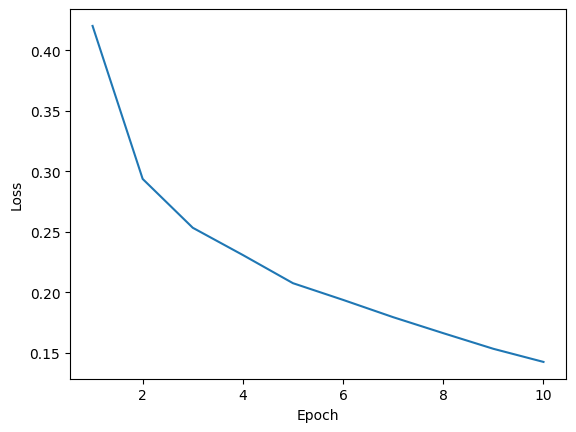

Test Accuracy: 90.08%


In [4]:
if __name__ == '__main__':
    num_epochs = 10
    train(num_epochs)
    test()